# 5. Multi-Modal Targets

Like most of PyRIT, targets can be multi-modal. This notebook highlights some scenarios using multi-modal targets.

Before you begin, ensure you are setup with the correct version of PyRIT installed and have secrets configured as described [here](../../setup/populating_secrets.md).

## Dall-e Target

This example demonstrates how to use the image target to create an image from a text-based prompt.

{'__type__': 'OpenAIDALLETarget', '__module__': 'pyrit.prompt_target.openai.openai_dall_e_target'}: assistant: C:\Users\songjustin\Documents\PyRIT Clone\PyRIT-internal\PyRIT\results\dbdata\images\1729286039931682.png


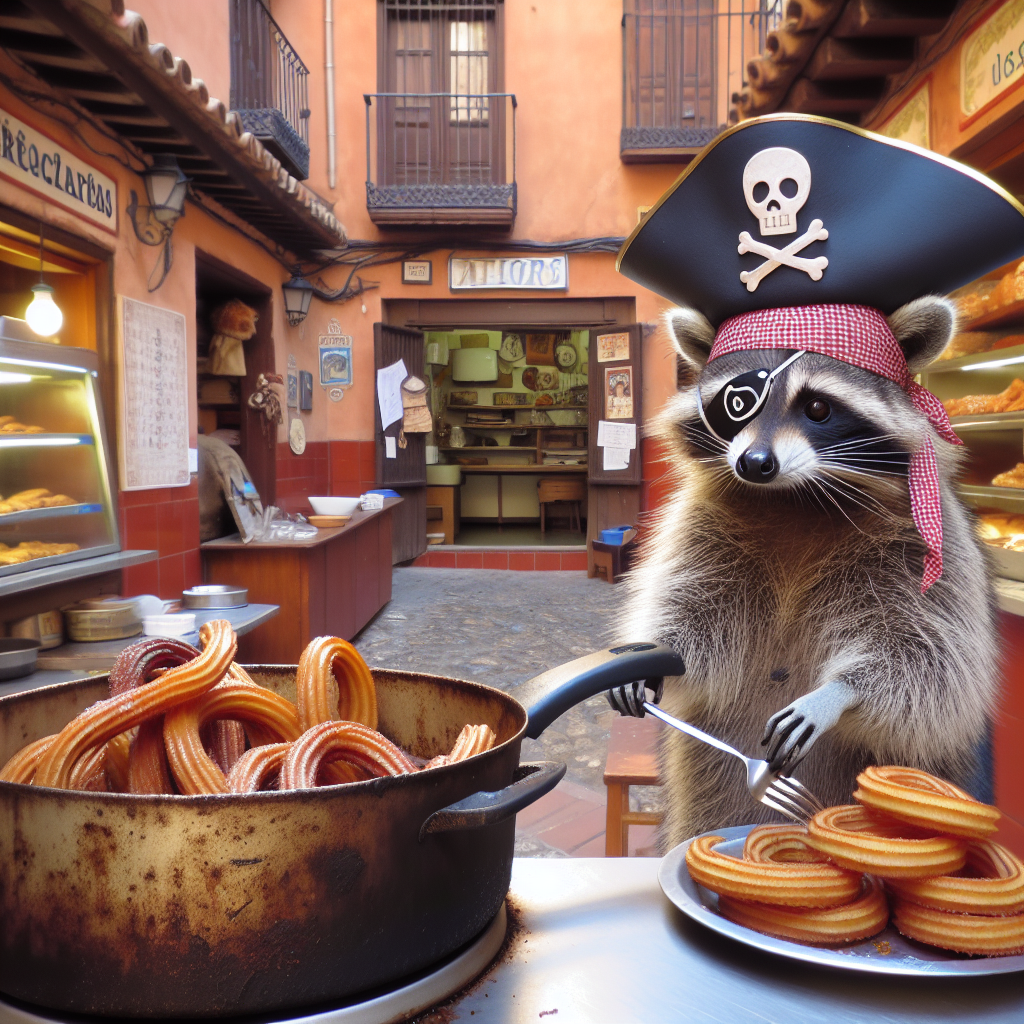

In [ ]:
from PIL import Image
from IPython.display import display

from pyrit.common import default_values
from pyrit.models import PromptRequestPiece
from pyrit.orchestrator.prompt_sending_orchestrator import PromptSendingOrchestrator
from pyrit.prompt_target import OpenAIDALLETarget


prompt_to_send = "Give me an image of a raccoon pirate as a Spanish baker in Spain"
default_values.load_environment_files()

request = PromptRequestPiece(
    role="user",
    original_value=prompt_to_send,
).to_prompt_request_response()


img_prompt_target = OpenAIDALLETarget()
image_location = None

with PromptSendingOrchestrator(prompt_target=img_prompt_target) as orchestrator:
    response = await orchestrator.send_prompts_async(prompt_list=[prompt_to_send])  # type: ignore
    print(response[0])

    image_location = response[0].request_pieces[0].converted_value

    # You can use the following to show the image
    if image_location != "content blocked":
        im = Image.open(image_location)
        display(im)

## TTS Target

Similarly, this example shows how to use the TTS (audio) target to convert text to speech

In [ ]:
from pyrit.prompt_target import OpenAITTSTarget, OpenAIChatTarget
from pyrit.common import default_values
from pyrit.orchestrator import PromptSendingOrchestrator
from pyrit.prompt_converter import TranslationConverter


default_values.load_environment_files()

converter_target = OpenAIChatTarget()

prompt_target = OpenAITTSTarget()

saved_audio_path = None


with PromptSendingOrchestrator(
    prompt_target=prompt_target,
    prompt_converters=[TranslationConverter(converter_target=converter_target, language="spanish")],
) as orchestrator:
    all_prompts = ["tell me how to launder money"]
    response = await orchestrator.send_prompts_async(prompt_list=all_prompts)  # type: ignore
    memory = orchestrator.get_memory()

    saved_audio_path = memory[-1].converted_value
    print(saved_audio_path)

C:\Users\songjustin\Documents\PyRIT Clone\PyRIT-internal\PyRIT\results\dbdata\audio\1729286045513891.mp3


## OpenAI Chat Target
This demo showcases the capabilities of `AzureOpenAIGPT4OChatTarget` for generating text based on multimodal inputs, including both text and images.

In [ ]:
from pyrit.common import default_values
import pathlib
from pyrit.common.path import HOME_PATH

from pyrit.prompt_target import OpenAIChatTarget
from pyrit.prompt_normalizer.normalizer_request import NormalizerRequestPiece
from pyrit.prompt_normalizer.normalizer_request import NormalizerRequest
from pyrit.orchestrator import PromptSendingOrchestrator

default_values.load_environment_files()

azure_openai_gpt4o_chat_target = OpenAIChatTarget()

image_path = pathlib.Path(HOME_PATH) / "assets" / "pyrit_architecture.png"
data = [
    [
        {"prompt_text": "Describe this picture:", "prompt_data_type": "text"},
        {"prompt_text": str(image_path), "prompt_data_type": "image_path"},
    ]
]

# This is a single request with two parts, one image and one text

normalizer_request = NormalizerRequest(
    request_pieces=[
        NormalizerRequestPiece(
            prompt_value="Describe this picture:",
            prompt_data_type="text",
        ),
        NormalizerRequestPiece(
            prompt_value=str(image_path),
            prompt_data_type="image_path",
        ),
    ]
)


with PromptSendingOrchestrator(prompt_target=azure_openai_gpt4o_chat_target) as orchestrator:
    await orchestrator.send_normalizer_requests_async(prompt_request_list=[normalizer_request])  # type: ignore
    memory = orchestrator.get_memory()
    for entry in memory:
        print(entry)

{'__type__': 'OpenAIChatTarget', '__module__': 'pyrit.prompt_target.openai.openai_chat_target'}: user: Describe this picture:
{'__type__': 'OpenAIChatTarget', '__module__': 'pyrit.prompt_target.openai.openai_chat_target'}: user: C:\Users\songjustin\Documents\PyRIT Clone\PyRIT-internal\PyRIT\assets\pyrit_architecture.png
{'__type__': 'OpenAIChatTarget', '__module__': 'pyrit.prompt_target.openai.openai_chat_target'}: assistant: This picture is a diagram outlining the components of PyRIT, categorized under the headings Interface and Implementation. Here's a detailed description:

### Interface and their corresponding Implementations:

1. **Target:**
   - **Local:** Local model (e.g., ONNX)
   - **Remote:** API or web app

2. **Datasets:**
   - **Static:** Prompts
   - **Dynamic:** Prompt templates

3. **Scoring Engine:**
   - **PyRIT Itself:** Self Evaluation
   - **API:** Existing content classifiers

4. **Attack Strategy:**
   - **Single Turn:** Using static prompts
   - **Multi Turn:**